# Multi-classification of chest X-ray images with a convolutional neural network

In [ ]:
import copy
import os
from PIL import Image
import sys
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
import torchvision
from torchvision import datasets, models, transforms
from tqdm import tqdm

%matplotlib inline

In [ ]:
print(f'Python version: {sys.version_info.major}.{sys.version_info.minor}')
print(f'PyTorch version: {torch.__version__}')
print(f'Torchvision version: {torchvision.__version__}')

def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    elif torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
        
    return device


device = get_device()
print(f'Using device: {device}')

In [3]:
def find_smallest_image(dataset_root: str) -> Tuple[int, str, Tuple[int, int]]:
    smallest_size = (float('inf'), float('inf'))
    smallest_file = ''
    
    total = 0
    for root, _, filenames in os.walk(dataset_root):
        for filename in filenames:
            if filename.endswith(('.jpg', '.png', '.jpeg')):
                path = os.path.join(root, filename)
                total += 1
                with Image.open(path) as image:
                    image_size = image.size
                    if (
                        image_size[0] * image_size[1] 
                        < smallest_size[0] * smallest_size[1]
                    ):
                        smallest_size = image_size
                        smallest_filename = filename

    return total, smallest_filename, smallest_size


TRAINING_FOLDER = 'datasets/train/'
TEST_FOLDER = 'datasets/test/'
total_files, smallest_image, smallest_size = find_smallest_image(TRAINING_FOLDER)
print(
    f"Training Dataset: {total_files} images found. " 
    f"Smallest image is {smallest_image} with size {smallest_size}"
)

total_files, smallest_image, smallest_size = find_smallest_image(TEST_FOLDER)
print(
    f"Testing Dataset: {total_files} images found. "
    f"Smallest image is {smallest_image} with size {smallest_size}"
)

Training Dataset: 251 images found. Smallest image is 092.png with size (439, 391)
Testing Dataset: 66 images found. Smallest image is 0120.jpg with size (416, 341)


## Data loading and preprocessing

In [4]:
IMAGE_SIZE = 400

TRAINING_PERCENTAGE = 0.7
VALIDATION_PERCENTAGE = 0.3

BATCH_SIZE = 10

In [5]:
full_train_dataset = datasets.ImageFolder(root=TRAINING_FOLDER)
training_dataset, validation_dataset = torch.utils.data.random_split(
    full_train_dataset, [TRAINING_PERCENTAGE, VALIDATION_PERCENTAGE]
)

test_dataset = datasets.ImageFolder(root=TEST_FOLDER)

### Data augmentation
For information about augmentation see:
https://pytorch.org/vision/stable/transforms.html

In [6]:
ROTATION_DEGREE = 20

In [7]:
resize = transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE))
to_tensor = transforms.ToTensor()

shared_transforms = [resize, to_tensor]

training_transforms = transforms.Compose([
    resize,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=20),
    to_tensor
])
training_dataset.dataset.transform = training_transforms

test_transforms = validation_transforms = transforms.Compose(shared_transforms)
validation_dataset.dataset.transform = validation_transforms

test_dataset = datasets.ImageFolder(root=TEST_FOLDER, transform=test_transforms)

In [8]:
training_loader = DataLoader(
    training_dataset, batch_size=BATCH_SIZE, shuffle=True
)
validation_loader = DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, shuffle=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)


if full_train_dataset.classes != test_dataset.classes:
  sys.exit("ERROR. Different number of classes detected in the training and testing datasets")


print(
    f'Dataset: \n'
    f'\t{len(training_dataset)} training images \n'
    f'\t{len(validation_dataset)} validation images \n'
    f'\t{len(test_dataset)} test images'
)

classes = test_dataset.classes
print(
    f'The dataset has {len(classes)} classes '
    f'i.e. {classes}'
)


Dataset: 
	176 training images 
	75 validation images 
	66 test images
The dataset has 3 classes i.e. ['Covid', 'Normal', 'Viral Pneumonia']


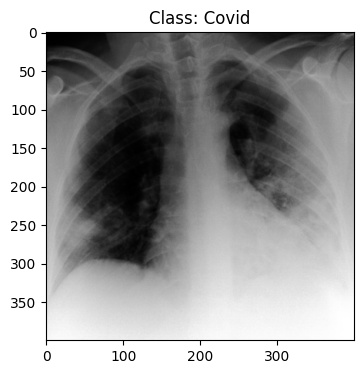

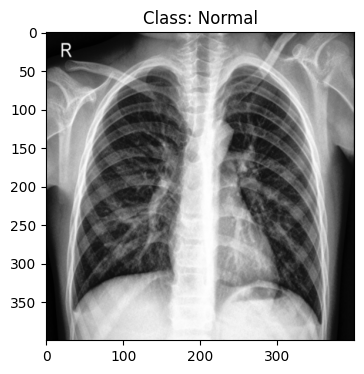

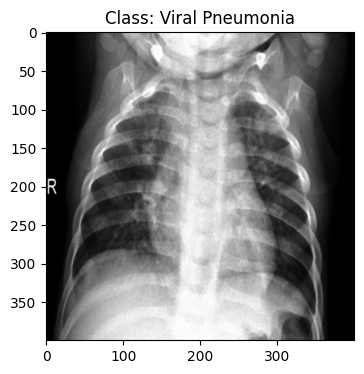

In [9]:
class_id = 0
while class_id < len(classes):
    for images, labels in training_loader:
        for image, label in zip(images, labels):
            if class_id == label:
                plt.figure(figsize=(8, 4))
                plt.title(f'Class: {classes[class_id]}')
                plt.imshow(image.permute(1, 2, 0))
                plt.show()
                
                class_id += 1


In [18]:

def train_model(
    model, criterion, optimizer, training_loader, validation_loader, num_epochs
):
    def train(epoch_loss):
        model.train()
        for _, (images, labels) in enumerate(training_loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            training_prediction = model(images)
            training_loss = criterion(training_prediction, labels)
            training_loss.backward()
            
            optimizer.step()

            epoch_loss += training_loss.item() * len(labels)
         
        epoch_loss /= len(training_loader.dataset)
        training_losses.append(epoch_loss)
        print(
            f'\r[Training] Epoch [{epoch + 1} / {num_epochs}], '
            f'Epoch Loss: {epoch_loss:.6f}'
        )
        
    def validate():
        model.eval()
        
        with torch.no_grad():
            validation_loss = 0

            for _, (images, labels) in enumerate(validation_loader):
                images = images.to(device)
                labels = labels.to(device)
                validation_prediction = model(images)
                validation_loss += criterion(
                    validation_prediction, labels
                ).item() * len(labels)

            validation_loss /= len(validation_loader.dataset)
            validation_losses.append(validation_loss)
            print(
                f'\r[Validation] Epoch [{epoch + 1} / {num_epochs}], '
                f'Validation Loss: {validation_loss:.6f}')
    
        return validation_loss
    
    training_losses = []
    validation_losses = []
    best_validation_loss = float('inf')

    model = model.to(device)
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        
        train(epoch_loss)
        validation_loss = validate()

        if validation_loss < best_validation_loss:
            best_model_state = copy.deepcopy(model.state_dict())
            print('\t Better model found')
    
            best_validation_loss = validation_loss

    return training_losses, validation_losses, best_model_state


def test_model(model, criterion, test_loader):
    num_correct = 0
    num_total = 0
    test_loss = 0
    true_labels = []
    predicted_labels = []
    
    model = model.to(device)

    model.eval()
    with torch.no_grad():
        for _, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            prediction = model(images)
            test_loss += criterion(prediction, labels).item() * len(labels)

            predicted_batch_labels = torch.argmax(prediction, dim=1)
            num_correct += (predicted_batch_labels == labels).sum().item()
            num_total += labels.size(0)
            true_labels.extend(labels.tolist())
            predicted_labels.extend(predicted_batch_labels.tolist())

    accuracy = num_correct / num_total
    test_loss /= num_total

    print(
        f'\nAccuracy score: {accuracy:.1%} '
        f'({num_correct} correct out of {num_total})')
    
    print(f'Test loss: {test_loss:.4f}')

    return (
        accuracy, 
        test_loss, 
        true_labels.numpy(), 
        predicted_labels.numpy(),
    )

In [11]:
def plot_loss(list1, list2, label1, label2):
    plt.figure(figsize=(10, 5))
    plt.title('Training and Validation Loss')
    plt.plot(list1, label=label1)
    plt.plot(list2, label=label2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [12]:
NUM_EPOCHS = 15
LEARNING_RATE = 3e-5
WEIGHT_DECAY = 1e-2

In [13]:
fine_tuned_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# replace the last layer with one with 3 output features
fine_tuned_model.fc = nn.Linear(fine_tuned_model.fc.in_features, 3)

criterion_ft = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(
    fine_tuned_model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY,
)

In [14]:
training_ft_losses, validation_ft_losses, best_ft_model_state = train_model(
    fine_tuned_model, 
    criterion_ft, 
    optimizer_ft, 
    training_loader, 
    validation_loader, 
    NUM_EPOCHS,
)
torch.save(best_ft_model_state, 'best_model.pth')
fine_tuned_model.load_state_dict(best_ft_model_state)

[Training] Epoch [1 / 15], Epoch Loss: 1.061349
[Validation] Epoch [1 / 15], Validation Loss: 1.067420
	 Better model found
[Training] Epoch [2 / 15], Epoch Loss: 0.921385
[Validation] Epoch [2 / 15], Validation Loss: 1.039685
	 Better model found
[Training] Epoch [3 / 15], Epoch Loss: 0.760864
[Validation] Epoch [3 / 15], Validation Loss: 0.983159
	 Better model found
[Training] Epoch [4 / 15], Epoch Loss: 0.591876
[Validation] Epoch [4 / 15], Validation Loss: 0.797620
	 Better model found
[Training] Epoch [5 / 15], Epoch Loss: 0.454869
[Validation] Epoch [5 / 15], Validation Loss: 0.510251
	 Better model found
[Training] Epoch [6 / 15], Epoch Loss: 0.311528
[Validation] Epoch [6 / 15], Validation Loss: 0.400240
	 Better model found
[Training] Epoch [7 / 15], Epoch Loss: 0.196516
[Validation] Epoch [7 / 15], Validation Loss: 0.327551
	 Better model found
[Training] Epoch [8 / 15], Epoch Loss: 0.148667
[Validation] Epoch [8 / 15], Validation Loss: 0.281958
	 Better model found
[Trainin

<All keys matched successfully>

In [15]:
import torch
from torch import nn
from torchvision import models

best_ft_model_state = torch.load('best_model.pth')
fine_tuned_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# replace the last layer with one with 3 output features
fine_tuned_model.fc = nn.Linear(fine_tuned_model.fc.in_features, 3)
fine_tuned_model.load_state_dict(best_ft_model_state)

criterion_ft = nn.CrossEntropyLoss()

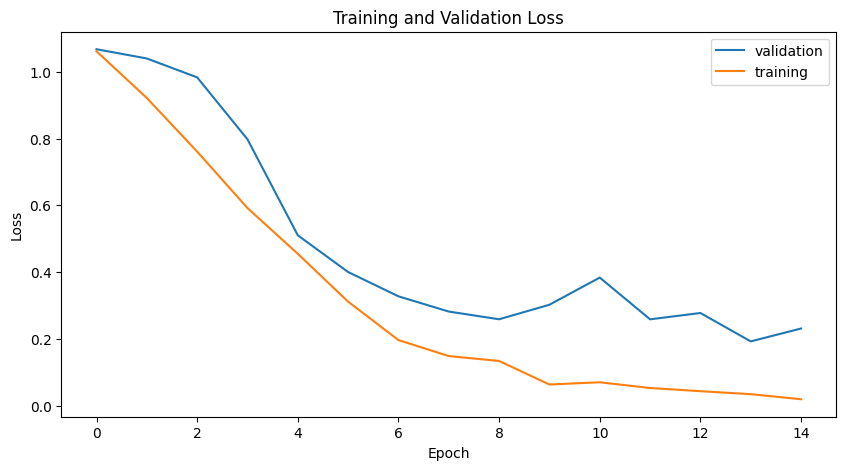

In [16]:
plot_loss(
    validation_ft_losses, 
    training_ft_losses,
    'validation',
    'training',
)

In [19]:
_, _, y_true, y_predicted = test_model(
    fine_tuned_model, 
    criterion_ft, 
    test_loader,
)
confusion_matrix_ = confusion_matrix(y_true, y_predicted)
print(confusion_matrix_)


Accuracy score: 89.4% (59 correct out of 66)
Test loss: 0.2906


AttributeError: 'list' object has no attribute 'numpy'